# **Automated Crater Detection Tutorial**

---



---

*featuring YOLOv3, YOLOv5 from Ultralytics*

Benson Chang S F, ACSE 2020-2021


# **Getting ready**


---


For the following tutorial, Google account is required (for Google Drive).

Click on the following shared directory (Msc_Project):

https://drive.google.com/drive/folders/1IoOYq4lGTFjVdtlSFHl5dwrGfO0WclMg?usp=sharing

It is assumed for the rest of the tutorial that this file (or its shortcut) is in your google drive. While logged onto a google account, add a shortcut of the directory to the Google Drive (My Drive) by choosing "Add Shortcut to Drive".
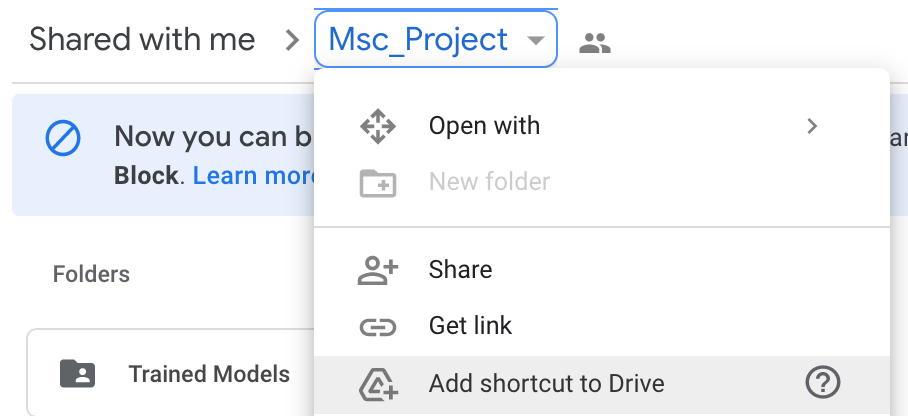



This directory has all the large files required, including labelled datasets and trained weights. You can choose to download this file and run similar bash commands on your local system if you wish to use your own GPU (suggestion: make sure you have 16GB of ram available when running YOLO). 

To enable GPU on colab, go to Edit -> Notebook settings and select GPU on "Hardware accelerator".

In [ ]:
# Mounts Google Drive
# Make sure to use the google account that has added the Msc_Project shortcut
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Connecting to Wandb for logging and monitoring
%pip install -q wandb
import wandb
wandb.login()

# **Setting up**

---


- Imports
- Tools (from Github repo)
- Crater datasets creating and augmentation (takes ~25mins to run)
- YOLOv3 and YOLOv5

## **Imports and Tools**

In [ ]:
# Imports
import os
import sys
from tqdm import tqdm
import torch
from IPython.display import Image, clear_output  # to display images
import pandas
from tifffile import imread
import numpy as np
import math
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle

# Function to download files
def download(path):
  from google.colab import files
  files.download(path)

In [ ]:
# Cloning personal github repo for tools
%cd /content/
!git clone https://github.com/acse-bsc4517/Crater-detection.git

/content
Cloning into 'Crater-detection'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 46 (delta 20), reused 38 (delta 16), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [ ]:
# Copying the set of tools to the appropriate position
%cd /content/Crater-detection/
!cp count_filter.py ../
!cp generate_txt.py ../
!cp lunar_dataset_create.py ../
!cp remove_id.py ../
!cp size_filter.py ../
!cp data_extract.py ../

/content/Crater-detection


## **Setting up Crater Data**
- This takes about 25 mins to run fully
- Here includes crater dataset from Benedix et al. 2020, it can be set up by uncommenting the cell contents

### Mars Dataset (Benedix) (1 min)
(Please remove the comment-out to use)

In [ ]:
"""%cd /content/
!cp /content/drive/MyDrive/Msc_Project/crater_data.zip ./
!unzip ./crater_data.zip -d ./

%cd /content/crater_data/
!mkdir images
!mv data_images/* images
!rm -rf data_images
!mkdir labels
!mv data_labels/* labels
!rm -rf data_labels
"""

###Mars Dataset (10mins)

In [ ]:
!cp /content/drive/MyDrive/Msc_Project/crater_group_dataset.zip /content/
!unzip /content/crater_group_dataset.zip -d /content/

In [ ]:
# Remove the id column from labels
%cd /content/
!python remove_id.py --dir crater_group_dataset

In [ ]:
# Removing files with small error
%cd /content/crater_group_dataset/labels/
!rm -rf ./-29_144.txt
!rm -rf ./-19_156.txt
!rm -rf ./-11_-157.txt
!rm -rf 24_167.txt
!rm -rf 10_157.txt
%cd ../images
!rm -rf ./-29_144.png
!rm -rf ./-19_156.png
!rm -rf ./-11_-157.png
!rm -rf 24_167.png
!rm -rf 10_157.png

In [ ]:
# Augment Mars dataset
%cd /content/crater_group_dataset/
!python aug.py --dataset . 

### Lunar Dataset (15mins)

In [ ]:
%cd /content/
!cp /content/drive/MyDrive/Msc_Project/lunar_crater_database_robbins_2018.csv .

In [ ]:
%cd /content/
# Download lunar surface mosaic image (~1 min)
!wget -P . https://planetarymaps.usgs.gov/mosaic/Lunar_LRO_LROC-WAC_Mosaic_global_100m_June2013.tif

# Creating dataset in yolov3 format (~4 minutes)
!python lunar_dataset_create.py

In [ ]:
!cp /content/crater_group_dataset/aug.py /content/dataset_lunar/

In [ ]:
# Augment the Lunar dataset
%cd /content/dataset_lunar/
!python aug.py --dataset .

## **YOLO Setup**

In [ ]:
# Cloning YoloV3 repo from ultralytics
%cd /content/
!git clone https://github.com/ultralytics/yolov3  # clone repo
%cd yolov3
%pip install -qr requirements.txt  # install dependencies

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
# Cloning YoloV5 repo from ultralytics
%cd /content/
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
%cd /content/Crater-detection/

# Copying modified yolo data and model yaml files
!cp YOLO_Setup/yolov3/lunardata_yolov3_test.yaml ../yolov3/data/
!cp YOLO_Setup/yolov3/lunardata_yolov3_train.yaml ../yolov3/data/
!cp YOLO_Setup/yolov3/marsdata_yolov3_train.yaml ../yolov3/data/
!cp YOLO_Setup/yolov3/marsdata_yolov3_test.yaml ../yolov3/data/
!cp YOLO_Setup/yolov3/yolov3_custom.yaml ../yolov3/models/
!cp train_tr.py ../yolov3

!cp YOLO_Setup/yolov5/lunardata_yolov5_test.yaml ../yolov5/data/
!cp YOLO_Setup/yolov5/lunardata_yolov5_train.yaml ../yolov5/data/
!cp YOLO_Setup/yolov5/marsdata_yolov5_trian.yaml ../yolov5/data/
!cp YOLO_Setup/yolov5/marsdata_yolov5_test.yaml ../yolov5/data/
!cp YOLO_Setup/yolov5/yolov5m_custom.yaml ../yolov5/models/

# **Studying Datasets**

---



In [ ]:
# Importing functions to obtain data of datasets
"""
get_data(directory: str)-> returns list
                           where each element in list is:
                           [[x, y, w, h], label textfile name]
                            
get_vals(data)          -> returns list of lists:
                           [countlist, woh_list, xy_list, d_list]
                           countlist = list of crater counts of image i
                           woh_list  = list of width/height of craters in image i
                           xy_list   = list of [x,y] positions of craters in image i                             
                           d_list    = list of crater diameters of craters in image i
"""
%cd /content/Crater-detection/
from data_extract import *

/content/Crater-detection


In [ ]:
%cd /content/
mars_data  = get_data('crater_group_dataset')
lunar_data = get_data('dataset_lunar')
mars_vals  = get_vals(mars_data)
lunar_vals = get_vals(lunar_data)

/content


Text(0.5, 0, 'Craters width')

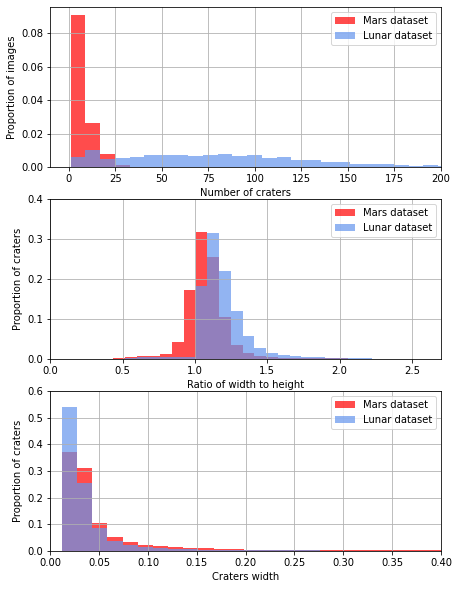

In [ ]:
# Plotting Data: 1.) histogram plot of crater number in picture
#                2.) histogram plot of w/h 
#                3.) histogram plot of w

fig, axs = plt.subplots(3,1, figsize = (7,10))
bins =np.histogram(np.hstack((mars_vals[0],lunar_vals[0])), bins=40)[1]
axs[0].grid()
axs[0].hist(mars_vals[0], bins, color = 'r', alpha = 0.7, label = 'Mars dataset', density=True)
axs[0].hist(lunar_vals[0], bins, color = 'cornflowerblue', alpha = 0.7, label = 'Lunar dataset', density=True)
axs[0].set_xlim([-10, 200])
axs[0].legend(loc = 'best')
axs[0].set_ylabel('Proportion of images')
axs[0].set_xlabel('Number of craters')

bins =np.histogram(np.hstack((mars_vals[1],lunar_vals[1])), bins=50)[1]
axs[1].grid()
x1, bins1, p1 = axs[1].hist(mars_vals[1], bins, color = 'r', alpha = 0.7, label = 'Mars dataset', density=True)
x2, bins2, p2 = axs[1].hist(lunar_vals[1], bins, color = 'cornflowerblue', alpha = 0.7, label = 'Lunar dataset', density=True)
for item in p1:
    item.set_height(item.get_height()/sum(x1))
for item in p2:
    item.set_height(item.get_height()/sum(x2))
axs[1].set_xlim([0, 2.7])
axs[1].set_ylim([0, 0.4])
axs[1].legend(loc = 'best')
axs[1].set_ylabel('Proportion of craters')
axs[1].set_xlabel('Ratio of width to height')

bins =np.histogram(np.hstack((mars_vals[3],lunar_vals[3])), bins=70)[1]
axs[2].grid()
x1, bins1, p1 = axs[2].hist(mars_vals[3], bins, color = 'r', alpha = 0.7, label = 'Mars dataset', density=True)
x2, bins2, p2 = axs[2].hist(lunar_vals[3], bins, color = 'cornflowerblue', alpha = 0.7, label = 'Lunar dataset', density=True)
axs[2].set_xlim([0, 0.4])
axs[2].set_ylim([0, 0.6])
for item in p1:
    item.set_height(item.get_height()/sum(x1))
for item in p2:
    item.set_height(item.get_height()/sum(x2))
axs[2].legend(loc = 'best')
axs[2].set_ylabel('Proportion of craters')
axs[2].set_xlabel('Craters width')

# **YOLO Training**


---

Training on both Mars and lunar dataset

In [ ]:
# Creating txt files within the dataset directory that lists which
# image + label file YOLO should read while training, validation and/or testing

# The training dataset created here has a train-validation ratio of 4:1 for both datasets
%cd /content/
!python generate_txt.py --train 0.8 --val 0.2 --test 0 --dir crater_group_dataset
!python generate_txt.py --train 0.8 --val 0.2 --test 0 --dir dataset_lunar 

/content
Total number of images considered = 12140
The number of images for
training = 9712
validation = 2428
testing = 0
Total number of images considered = 1214
The number of images for
training = 607
validation = 607
testing = 0


To make sure the YOLO recognises where to read this list of .txt files, prase the appropriate .yaml file on the ```--data``` flag. During training/testing the respective options are:

For YOLOv3:
```
marsdata_yolov3_train.yaml
marsdata_yolov3_test.yaml
lunardata_yolov3_train.yaml
lunardata_yolov3_test.yaml
```

For YOLOv5m
```
marsdata_yolov5_train.yaml
marsdata_yolov5_test.yaml
lunardata_yolov5_train.yaml
lunardata_yolov5_test.yaml
```

## YOLOv3


In [ ]:
# Training YOLOv3 on Mars dataset
%cd /content/yolov3/
!python train.py --img 593 --batch 16 --epochs 60 --data marsdata_yolov3_train.yaml --weights yolov3.pt

In [ ]:
# Training YOLOv3 on lunar dataset
%cd /content/yolov3/
!python train.py --img 593 --batch 16 --epochs 50 --data lunardata_yolov3_train.yaml --weights yolov3.pt

## YOLOv5m

In [ ]:
# Training YOLOv5m on Mars dataset
%cd /content/yolov5/
!python train.py --img 593 --batch 16 --epochs 50 --data marsdata_yolov5_trian.yaml --weights yolov5m.pt --cfg yolov5m_custom.yaml

In [ ]:
# Training YOLOv5m on lunar dataset
%cd /content/yolov5/
!python train.py --img 593 --batch 16 --epochs 50 --data lunardata_yolov5_train.yaml --weights yolov5m.pt --cfg yolov5m_custom.yaml

# **YOLO transfer learning**


---

- Training with newly crater-trained weights, and with certain layers frozen.

- The weights (.pt files) from the training previously are within the YOLO run/ directories, e.g. ```/content/yolov3/runs/train/exp/weights/best.pt```. 

- Alternatively, the weights in the Msc_Project folder can also be used. For example, the YOLOv3 Mars-trained weights are in ```Msc_Project/trained_models/M3/weights/best.pt```.

## YOLOv3
- YOLOv3 has a total of 11 (backbone) + 18 (head) layers.
- A modified train file (train_tr.py) is used here for YOLOv3 along with the ```---freeze``` flag
- e.g. To freeze the backbone, use ```--freeze 11```

In [ ]:
# Example of performing a transfer-learning on a weights trained on Mars craters
%cd /content/
!python generate_txt.py --train 0.5 --val 0.5 --test 0 --dir dataset_lunar --size 2428
%cd /content/yolov3/
!python train_tr.py --img 593 --batch 16 --epochs 50 --data lunardata_yolov3_train.yaml --cfg yolov3_custom.yaml --weights /content/drive/MyDrive/Msc_Project/trained_models/M3/weights/best.pt --freeze 11

## YOLOv5m
- YOLOv5m has a total of 10 (backbone) + 14(head) layers

In [ ]:
%cd /content/yolov5/
!python train.py --img 593 --batch 16 --epochs 50 --data lunardata_yolov5_train.yaml --weights /content/drive/MyDrive/Msc_Project/trained_models/M5m/weights/best.pt --cfg yolov5m_custom.yaml --freeze 10

# **YOLO Testing**


---

Note that YOLOv3 uses ```test.py``` during testing and YOLOv5 uses ```val.py```. when using test.py with YOLOv3, a ```--task test``` flag is required.

##Testing on a dataset with crater count-per-image filtered
- ```count_filter.py``` acts similar to generate_txt.py where it creates a ```test.txt``` file. The file lists all the images (that YOLO parses) which has a crater count ≥ ```min``` and < ```max```. 
- Use the ```--dir``` to parse in which dataset directory to target.

In [ ]:
%cd /content/
!python count_filter.py --dir dataset_lunar --min 5 --max 10
%cd /content/yolov5/
!python val.py --weights /content/drive/MyDrive/Msc_Project/trained_models/M5m/weights/best.pt --data lunardata_yolov5_test.yaml --iou 0.5 --img 593

## Testing on dataset with crater size filtered
- Use ```size_filter.py``` to create a new set of labels that records all craters that have width and height ≥ ```min``` and < ```max``` and ignoring all else. 
- Once filtered, a ```test.txt``` can be created via ```generate_txt.py```. 
- The original labels are stored in the original_labels inside the dataset directory and can be recovered by using the ```--revert``` flag

In [ ]:
# filtering crater size 
%cd /content/
!python size_filter.py --dir dataset_lunar --min 10 --max 15
!python generate_txt.py --dir dataset_lunar --train 0 --val 0 --test 1
%cd yolov5/
!python val.py --weights /content/drive/MyDrive/Msc_Project/trained_models/M5m/weights/best.pt --data lunardata_yolov5_test.yaml --iou 0.5 --img 593 

In [ ]:
|# Recovering the unfiltered (original) labels
%cd /content/
!python size_filter.py --dir dataset_lunar --revert True